# **Esercizio di Analisi dei Dati sui Contagi COVID-19** 
**Obiettivo**: Questo programma ha come scopo l'analisi dell'andamento dei contagi COVID-19
in Friuli Venezia Giulia, utilizzando i dati forniti dalla Protezione Civile Italiana (si è utilizzato il
file “dpc-covid19-ita-regioni.csv” contenuto in “dati-regioni”).


Installiamo alcune librerie utili per implementare grafici e algoritmi:

In [2]:
!pip install emcee
!pip install corner
!pip install pygtc
import numpy as np
import pandas as pd
import random as ran
import matplotlib.pyplot as plt
import matplotlib as mpll
from scipy.stats import norm
from scipy.stats import lognorm
from scipy.stats import poisson
from scipy.integrate import cumtrapz
from scipy.interpolate import interp1d
from scipy.optimize import minimize
from scipy.special import gamma
import math as mt
import emcee

Codice per ottimizzare le equazioni scritte in formato latex nelle celle markdown

In [3]:

%%javascript
MathJax.Hub.Config({
    TeX: { equationNumbers: { autoNumber: "AMS" } }
});


<IPython.core.display.Javascript object>

# **Parte 1: Analisi dell'Andamento dei Nuovi Contagi**  
Scarichiamo il dataset dei contagi COVID-19 dal file "dpc-covid19-ita-regioni.csv" e grafichiamo l'andamento dei contagi COVID-19 per tutta la durata dell'epidemia in Friuli Venezia Giulia.

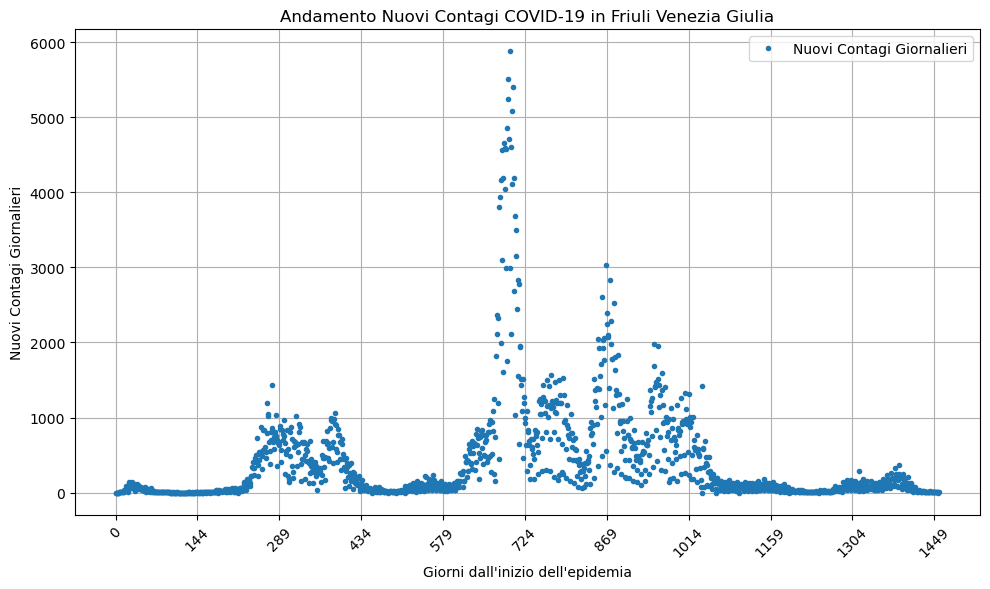

In [22]:
import pandas as pd
import matplotlib.pyplot as plt

# Importa
file_path = "dpc-covid19-ita-regioni.csv"
df = pd.read_csv(file_path)

# Regione
df_regione = df[df['denominazione_regione'] == 'Friuli Venezia Giulia'].copy()

# Creare gli array
dates_array = df_regione['data'].to_numpy()
daily_cases_array = df_regione['nuovi_positivi'].to_numpy()

# Calcola giorni dall'inizio dell'epidemia
start_date = pd.to_datetime(dates_array[0])
days_since_start = [(pd.to_datetime(date) - start_date).days for date in dates_array]

# Campiono 10 date per la legenda
num_date = 10
sampled_dates = days_since_start[::len(days_since_start) // num_date]
sampled_daily_cases = daily_cases_array[::len(daily_cases_array) // num_date]

# Grafico dei contagi
plt.figure(figsize=(10, 6))
plt.plot(days_since_start, daily_cases_array, '.', label='Nuovi Contagi Giornalieri')
plt.title(f'Andamento Nuovi Contagi COVID-19 in Friuli Venezia Giulia')
plt.xlabel('Giorni dall\'inizio dell\'epidemia')
plt.ylabel('Nuovi Contagi Giornalieri')
plt.xticks(sampled_dates, rotation=45)  # Utilizzare solo le date campionate
plt.legend()
plt.grid(True)
plt.tight_layout()

# Visualizzare il grafico
plt.show()




# **Parte 2: Implementazione dei Modelli Epidemiologici**

Introduciamo ora due funzioni per modellizzare l'andamento dell'epidemia e le relative funzioni associate ai numeri di casi giornalieri:  
    
**Funzione logistica:**  
$$L(t) = \frac{N_{\text{tot}}}{1 + e^{-k \cdot (t - t_0)}}$$  
Dove $N_{tot}$ rappresenta il numero di casi totali a fine epidemia, $k$ è un coefficiente proporzionale alla velocità di propagazione del contaglio e $t_0$ rappresenta dopo quanto tempo si ha il picco del numero di casi cioè $L'(t_0)>0$ e $L''(t_0)=0$.  

**Funzione di Gompertz:**  
$$G(t) = N_{\text{tot}} \cdot e^{-\log(N_{\text{tot}}) \cdot e^{-k \cdot (t - t_0)}}$$  
Dove $N_{tot}$ rappresenta il numero di casi totali a fine epidemia, $k$ è un coefficiente proporzionale alla velocità di propagazione del contaglio e  $t_0$ rappresenta l'inizio della crescita dei contagi e $G(t_0) \approx$ 1.


Definiamo e grafichiamo la funzione logistica (logistic_function) e la funzione ad essa associata (logistic_daily_cases) che descrive il numero di nuovi casi giornalieri previsti:

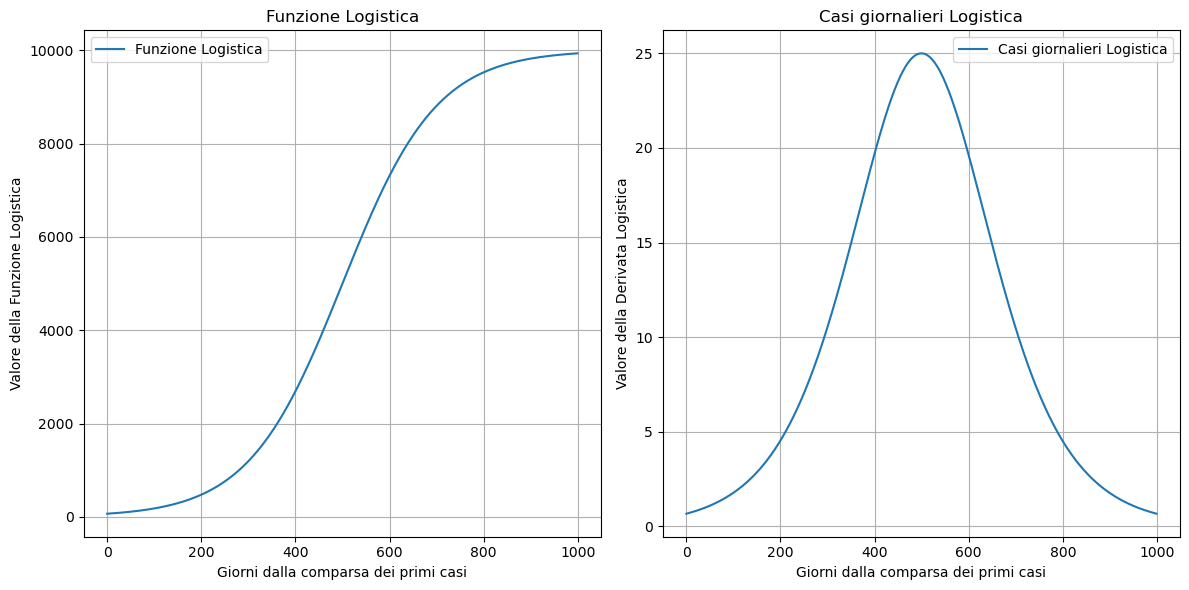

In [5]:
import numpy as np
import matplotlib.pyplot as plt

def logistic_function(N_tot, k, t_0, t):
    return N_tot / (1 + np.exp(-k * (t - t_0)))

def logistic_daily_cases(N_tot, k, t_0, t):
    return logistic_function(N_tot, k, t_0, t + 1) - logistic_function(N_tot, k, t_0, t)

# Esempio di utilizzo  
t_values = np.arange(0, 1000, 1)  # Array di tempi da 0 a 999
N_tot_example = 10000
k_example = 0.01
t0_example = 500

logistic_values = logistic_function(N_tot_example, k_example, t0_example, t_values)
daily_cases_logistic = logistic_daily_cases(N_tot_example, k_example, t0_example, t_values)

# Visualizzazione dei risultati
plt.figure(figsize=(12, 6))

# Grafico della funzione logistica
plt.subplot(1, 2, 1)
plt.grid(True)
plt.plot(t_values, logistic_values, label='Funzione Logistica')
plt.title('Funzione Logistica')
plt.xlabel('Giorni dalla comparsa dei primi casi')
plt.ylabel('Valore della Funzione Logistica')
plt.legend()

# Grafico della derivata della funzione logistica
plt.subplot(1, 2, 2)
plt.grid(True)
plt.plot(t_values, daily_cases_logistic, label='Casi giornalieri Logistica')
plt.title('Casi giornalieri Logistica')
plt.xlabel('Giorni dalla comparsa dei primi casi')
plt.ylabel('Valore della Derivata Logistica')
plt.legend()

plt.tight_layout()
plt.show()


Definiamo e grafichiamo la funzione di Gompertz (gompertz_function) e la funzione ad essa associata (gompertz_daily_cases) che descrive il numero di nuovi casi giornalieri previsti:

Valore di daily_cases_gompertz a t_0 (100): 0.09597504370882382


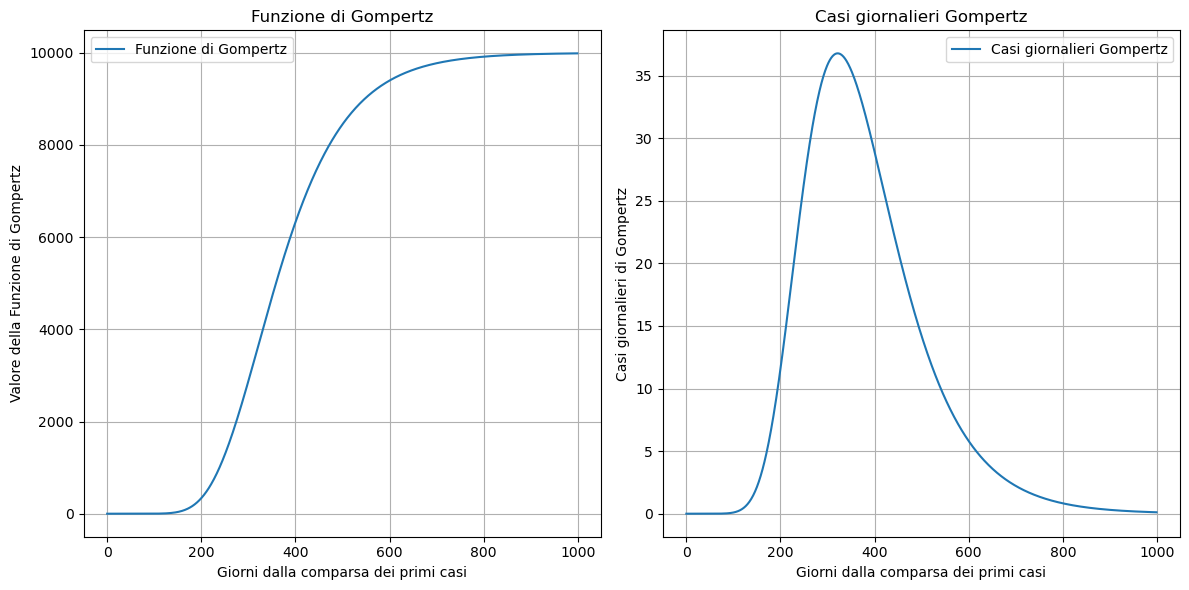

In [6]:
import numpy as np
import matplotlib.pyplot as plt

def gompertz_function(N_tot, k, t_0, t):
    return N_tot * np.exp(-np.log(N_tot) * np.exp(-k * (t - t_0)))

def gompertz_daily_cases(N_tot, k, t_0, t):
    return gompertz_function(N_tot, k, t_0, t + 1) - gompertz_function(N_tot, k, t_0, t)

# Esempio di utilizzo
t_values = np.arange(0, 1000, 1)  # Array di tempi da 0 a 999
N_tot_example = 10000
k_example = 0.01
t0_example = 100

gompertz_values = gompertz_function(N_tot_example, k_example, t0_example, t_values)
daily_cases_gompertz = gompertz_daily_cases(N_tot_example, k_example, t0_example, t_values)

# Stampa il valore di daily_cases_gompertz quando t_values == t_0
index_t0 = np.where(t_values == t0_example)[0][0]
print(f'Valore di daily_cases_gompertz a t_0 ({t0_example}): {daily_cases_gompertz[index_t0]}')

# Visualizzazione dei risultati
plt.figure(figsize=(12, 6))

# Grafico della funzione di Gompertz
plt.subplot(1, 2, 1)
plt.grid(True)
plt.plot(t_values, gompertz_values, label='Funzione di Gompertz')
plt.title('Funzione di Gompertz')
plt.xlabel('Giorni dalla comparsa dei primi casi')
plt.ylabel('Valore della Funzione di Gompertz')
plt.legend()

# Casi giornalieri funzione di Gompertz
plt.subplot(1, 2, 2)
plt.grid(True)
plt.plot(t_values, daily_cases_gompertz, label='Casi giornalieri Gompertz')
plt.title('Casi giornalieri Gompertz')
plt.xlabel('Giorni dalla comparsa dei primi casi')
plt.ylabel('Casi giornalieri di Gompertz')
plt.legend()

plt.tight_layout()
plt.show()


# **Parte3: Analisi della Prima Ondata**

Ora ci concentriamo sull'andamento dei contagi in Friuli Venezia Giulia durante i primi 35 giorni, fino al 30 marzo 2020, e li grafichiamo.

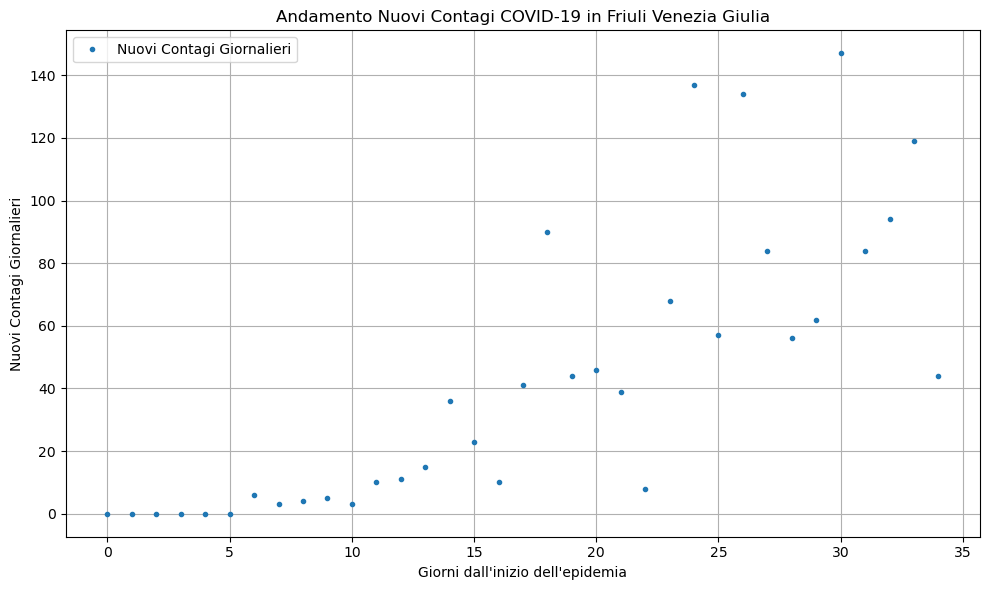

In [23]:
# Considero solo le prime 35 date
# Definisci la data finale
datafin = "2020-03-30T00:00:00"

# Crea una nuova serie di date con le prime 35
datarid = data[data <= datafin]

# Considero i contagi associati al set
n_positivirid = n_positivi[data <= datafin]

t = np.arange(0, len(datarid), 1)
Nosservati = n_positivirid

plt.figure(figsize=(10, 6))
plt.plot(t, n_positivirid, '.', label='Nuovi Contagi Giornalieri')
plt.title(f'Andamento Nuovi Contagi COVID-19 in Friuli Venezia Giulia')
plt.xlabel('Giorni dall\'inizio dell\'epidemia')
plt.ylabel('Nuovi Contagi Giornalieri')
plt.legend()
plt.grid(True)
plt.tight_layout()

Ora supponiamo che ogni valore per il numero di casi sia una variabile casuale associata ad una distribuzione poissoniana centrata nel valore corrispondente dato dalla funzione logistica (o di Gompertz). 
Abbiamo quindi un campione di variabili casuali $X_1, X_2, ... X_{35}$  
La poissoniana è data da:
$$ P(X = k; \lambda) = \frac{e^{-\lambda} \cdot \lambda^k}{k!} $$
Cioè la probabilità che una variabile casuale assuma il valore $X=k$ quando $\lambda$ è il valore previsto dalla logistica (o da Gompertz).  

La corrispondente likelihood associata al campione è:

$$L(\lambda_1, \lambda_2, \ldots, \lambda_n; x_1, x_2, \ldots, x_n) = \prod_{i=1}^{n} \frac{e^{-\lambda_i} \cdot \lambda_i^{x_i}}{x_i!}$$

La log likelihood sarà quindi:

$$
\log L(\lambda_1, \lambda_2, \ldots, \lambda_n; x_1, x_2, \ldots, x_n) = \sum_{i=1}^{n} \left( -\lambda_i + x_i \cdot \log(\lambda_i) - \log(x_i!) \right)
$$


Algoritmo EMCEE

Vogliamo quindi usare il campione statistico poissoniano per stimare i parametri delle distribuzioni che meglio descrivono l'andamento dei contagi nei primi 35 giorni e le loro incertezze.
Usiamo a questo proposito l'algoritmo EMCEE, implementazione del campionamento Markov Chain Monte Carlo per l'analisi bayesiana.
L'algoritmo sfrutta la distribuzione prior e la likelihood per stimare la distribuzione posterior dei parametri. 
La prior è una distribuzione uniforme nello spazio dei parametri che tiene conto di alcuni vincoli su questi dipendenti solo dal modello e non dall'osservazione dei dati sperimentali.  
$N_{tot}>0$,  $k>0$,  $t_0>0$    
L'algoritmo EMCEE si basa su un insieme di "walkers" che esplorano lo spazio dei parametri muovendosi secondo l'algoritmo MH in una maniera che dipende dalla posizione degli altri walkers. l'approccio riduce il rischio di rimanere intrappolati in minimi locali e migliora l'efficienza di campionamento nello spazio parametrico. 
Il risultato è un campione Monte Carlo che segue la "posterior distribution" dei parametri $N_{tot}, k, t_0$ che voglio stimare.  
Da tale campione si estrae la miglior stima dei parametri, usando la media sugli elementi del campione, grazie alla legge dei grandi numeri, e l'incertezza associata, calcolando l'intervallo corrispondente ad una deviazione standard, tra 16o e 84o percentile.
Implementiamo quindi l'algoritmo sia per la funzione logistica che per la funzione di Gompertz.

C:\Users\loren\anaconda3\Lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\loren\anaconda3\Lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


[1.90513123e+03 2.08769532e-01 2.89595269e+01]


100%|██████████| 10000/10000 [00:17<00:00, 567.34it/s]


[38.07091312 38.75480233 38.59396991]
(316800, 3)


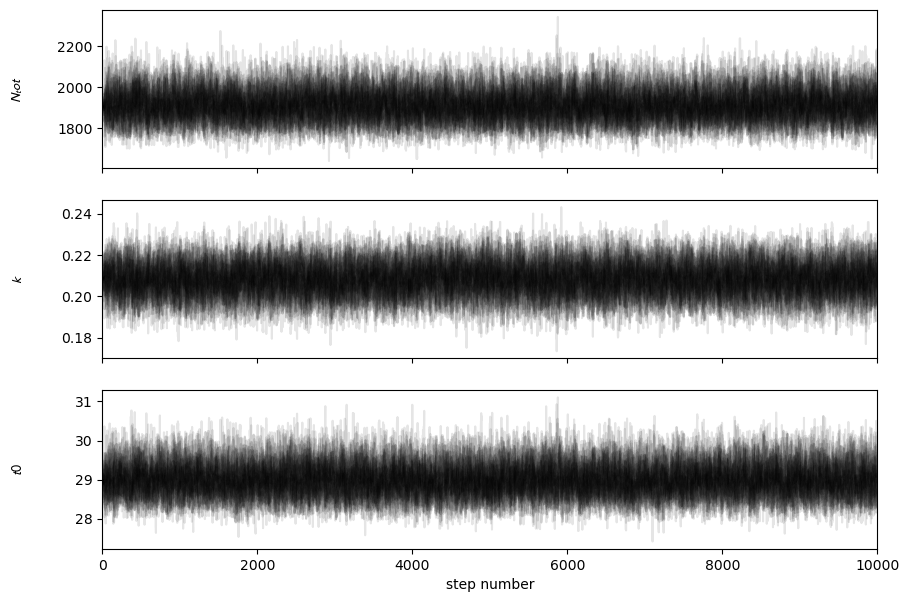

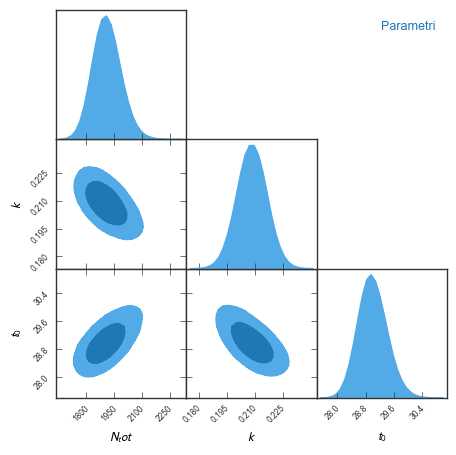

In [472]:
#LOGISTICA

# l'uso dei logaritmi delle distribuzioni è dovuto alla maggior efficienza computazionale di svolgere somme anzichè prodotti

# Calcolo della log-likelihood della distribuzione di Poisson

# probabilità di ottenere il set di dati sperimentali osservati fissati i parametri e la distribuzione.

def log_likelihood(params, t, osservati): #likelihood poissoniana associata alla logistica
    Ntot, k, t_0 = params
    predetti= logistic_daily_cases(Ntot, k, t_0, t)
    log_likelihood = np.sum( (-predetti) +  (osservati)*(np.log(predetti)) - (np.log(gamma(osservati.astype(int) + 1))) )
    return log_likelihood


# Definizione del logaritmo del prior piatto

# distribuzione dei parametri dipendente solo dal modello statistico scelto inizialmente e non dai dati

def log_prior(params):
    Ntot, k, t_0 = params
    if Ntot > 0 and k > 0 and t_0 >0:
        return 0
    return -np.inf

# distribuzione dei parametri alla luce del modello e dei dati

# Definizione del logaritmo del posterior

def log_posterior(params, t, osservati):
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(params, t, osservati)

# Dati osservati nei primi 35 giorni dell'epidemia
t = np.arange(0, 35,1)  
Nosservati = n_positivirid.to_numpy()


#PARAMETRI INIZIALI 

Ntotini = np.sum(Nosservati) # Totale dei contagi a fine ondata epidemica (somma dei contagi giornalieri)
kini = 0.5 # Velocità di propagazione del contagio
t0ini = 20  # Picco prima ondata


# Inizializzazione dei parametri
parametri_iniziali = [Ntotini, kini, t0ini]  # Inserire valori iniziali per Ntot, k, x0


# Definisco la funzione da minimizzare, ovvero la log_posterior cambiata di segno poichè voglio in realtà massimizzarla
nll = lambda *args: -log_posterior(*args)

# Ottimizzazione della log-likelihood
result = minimize(nll, parametri_iniziali, args=(t, Nosservati))

# Estrazione dei parametri stimati
LNtot_estimated, Lk_estimated, Lt0_estimated = result.x

#result.x è un vettore che contiene i valori dei parametri che minimizzano la funzione obiettivo.

print(result.x)

ndim=3 #numero parametri modello
nwalkers=32 #numero di walkers opportunamente scelto pari a circa 10 volte il numero di parametri da stimare

#i walkers vengono inizializzati a partire dalla combinazione di parametri che massimizzano la log_posterior
pos = result.x *(1+ 1e-4 * np.random.randn( nwalkers , ndim ))
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(t,Nosservati))
sampler.run_mcmc(pos, 10000, progress=True);
#preferibile che il numero di step sia almeno una cinquantina di volte il tempo di autocorrelazione per ogni parametro


fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["$N_tot$","$k$", "$t0$"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.1)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

#stampa il tempo di autocorrelazione, cioè il tempo necessario a decorrelare campionamenti successivi
#è necessario che tau sia basso rispetto al numero totale di step di ciascuna catena di Markov

tau = sampler.get_autocorr_time()
print(tau)
flat_samples = sampler.get_chain(discard=100, flat=True)
print(flat_samples.shape)

#stampa le posterior distribution e le covarianze tra i parametri, che rappresentano il tempo 
#passato dalle catene di Markov in ciascuna 'regione' all'interno dello spazio dei parametri

import pygtc
GTC = pygtc.plotGTC(chains=flat_samples,
                    paramNames=['$N_tot$','$k$','$t_0$'],
                    chainLabels=['Parametri'],
                    figureSize='MNRAS_page')



# Calcolo dei valori stimati dei parametri e delle incertezze
Lestimated_params = np.mean(samples, axis=(0,1)) #media
Lparam_uncertainties = np.percentile(samples, [16, 84], axis=(0,1)) - Lestimated_params
#calcolo dell'incertezza come differenza tra valori associati a 16o e 84o percentile e media





In [473]:
#parametri stimati per la distribuzione logistica

print(Lestimated_params)
print(Lparam_uncertainties)

[1.91203942e+03 2.08332750e-01 2.89977426e+01]
[[-7.07448356e+01 -7.59473307e-03 -3.88392728e-01]
 [ 7.06071968e+01  7.55738761e-03  3.87308691e-01]]


100%|██████████| 5000/5000 [00:10<00:00, 491.46it/s]


[37.01746167 38.12828137 39.96848908]
(156800, 3)


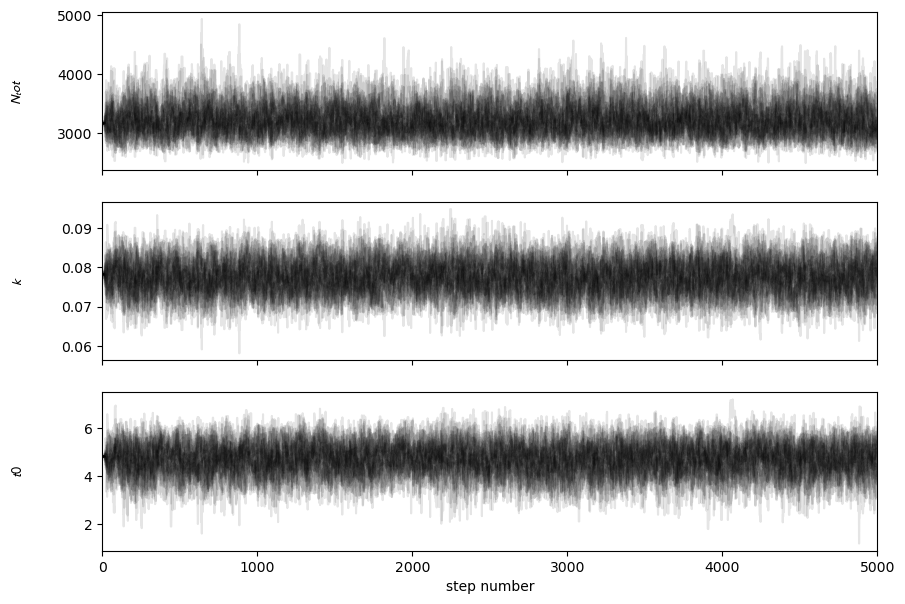

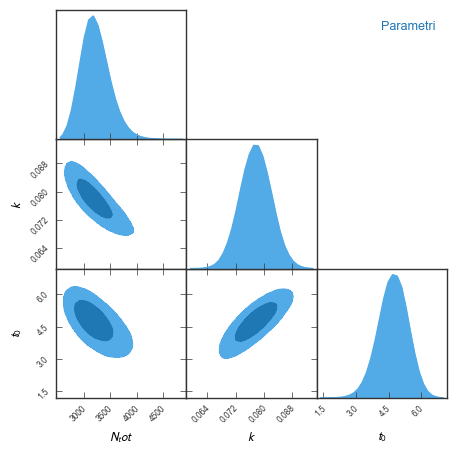

In [474]:
#GOMPERTZ

# l'uso dei logaritmi delle distribuzioni è dovuto alla maggior efficienza computazionale di svolgere somme anzichè prodotti

# Calcolo della log-likelihood della distribuzione di Poisson

# probabilità di ottenere il set di dati sperimentali osservati fissati i parametri e la distribuzione.

def log_likelihood(params, t, osservati): #likelihood poissoniana associata a gompertz
    Ntot, k, t_0 = params
    predetti= gompertz_daily_cases(Ntot, k, t_0, t)
    log_likelihood = np.nansum( (-predetti) +  (osservati)*(np.log(predetti)) - (np.log(gamma(osservati.astype(int) + 1))) )
    return log_likelihood

# Definizione del logaritmo del prior piatto

# distribuzione dei parametri dipendente solo dal modello statistico scelto inizialmente e non dai dati

def Glog_prior(params):
    Ntot, k, t_0 = params
    if Ntot > 0 and k > 0 and t_0 > 0:
        return 0
    return -np.inf

# distribuzione dei parametri alla luce del modello e dei dati

# Definizione del logaritmo del posterior

def log_posterior(params, t, osservati):
    Ntot, k, t_0 = params
    lp = Glog_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(params, t, osservati)


# Dati osservati nei primi 35 giorni dell'epidemia

t = np.arange(0, 35,1) 
Nosservati = n_positivirid.to_numpy()


#PARAMETRI INIZIALI 

Ntotini = np.sum(Nosservati)# Totale dei contagi a fine ondata epidemica
kini = 0.1# Velocità di propagazione del contagio
t0ini = 5 # Giorno di contagio del paziente 0

# Inizializzazione dei parametri
parametri_iniziali = [Ntotini, kini, t0ini]  # Inserire valori iniziali per Ntot, k, x0

nll = lambda *args: -log_posterior(*args)

# Ottimizzazione della log-likelihood
result = minimize(nll, parametri_iniziali, args=(t, Nosservati))

# Estrazione dei parametri stimati
GNtot_estimated, Gk_estimated, Gt0_estimated = result.x

#Inizializzazione di emcee
ndim=3 #numero parametri modello
nwalkers=32 #numero di walkers opportunamente scelto pari a circa 10 volte il numero di parametri da stimare

#i walkers vengono inizializzati a partire dalla combinazione di parametri che massimizzano la log_posterior

pos = result.x *(1+ 1e-4 * np.random.randn( nwalkers , ndim ))
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_posterior, args=(t,Nosservati)
)
sampler.run_mcmc(pos, 5000, progress=True);  
#preferibile che il numero di step sia una cinquantina di volte il tempo di autocorrelazione per ogni parametro


fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["$N_tot$","$k$", "$t0$"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.1)  #il parametro alpha regola la trasparenza delle linee
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

#stampa il tempo di autocorrelazione, cioè il tempo necessario a decorrelare campionamenti successivi
#è necessario che tau sia basso rispetto al numero totale di step di ciascuna catena di Markov

tau = sampler.get_autocorr_time()
print(tau)
flat_samples = sampler.get_chain(discard=100, flat=True)
print(flat_samples.shape)

#stampa le posterior distribution e le covarianze tra i parametri, che rappresentano il tempo 
#passato dalle catene di Markov in ciascuna 'regione' all'interno dello spazio dei parametri 

import pygtc
GTC = pygtc.plotGTC(chains=flat_samples,
                    paramNames=['$N_tot$','$k$','$t_0$'],
                    chainLabels=['Parametri'],
                    figureSize='MNRAS_page')

# Calcolo dei valori stimati dei parametri e delle incertezze

Gestimated_params = np.mean(samples, axis=(0,1)) #media
Gparam_uncertainties = np.percentile(samples, [16, 84], axis=(0,1)) - Gestimated_params 
#calcolo dell'incertezza come differenza tra valori associati a 16o e 84o percentile e media




In [475]:
print(Gestimated_params)
print(Gparam_uncertainties)

[3.22075377e+03 7.76272178e-02 4.69871365e+00]
[[-2.50496820e+02 -4.20488823e-03 -6.38375657e-01]
 [ 2.49421466e+02  4.19164747e-03  6.39855628e-01]]


Ora che abbiamo stimato i parametri per le due distribuzioni, calcolati sui dati dei primi 35 giorni, proviamo a confrontare le previsioni del modello con i dati effettivi propagando l'incertezza teorica associata. Confrontiamo prima con i dati dei primi 35 giorni e poi con i dati dei primi 100 giorni, sia giornalieri che cumulativi.

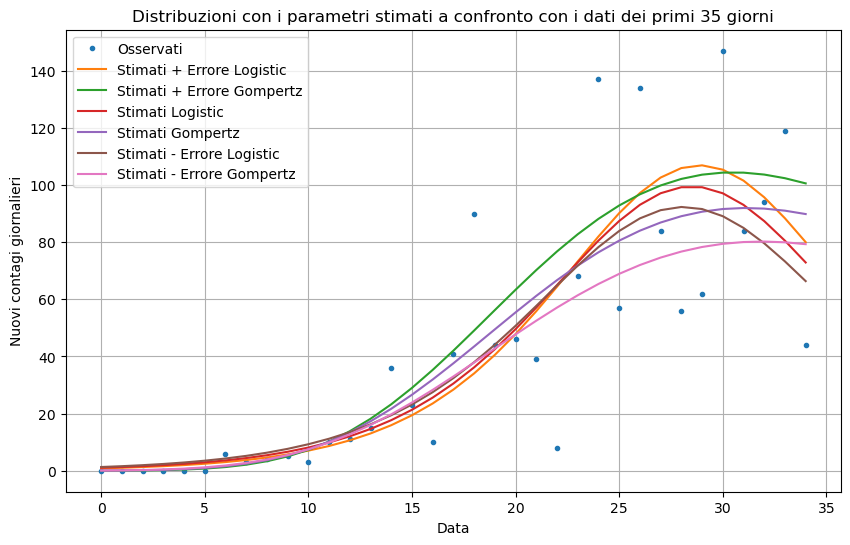

In [476]:
#intervallo temporale 35 giorni

t = np.arange(0, 35,1)  

#Distribuzione con i parametri stimati più l'errore 

PLN_tot=Lestimated_params[0]+Lparam_uncertainties[1,0]
PLk=Lestimated_params[1]+Lparam_uncertainties[1,1]
PLt0=Lestimated_params[2]+Lparam_uncertainties[1,2]

PGN_tot=Gestimated_params[0]+Gparam_uncertainties[1,0]
PGk=Gestimated_params[1]+Gparam_uncertainties[1,1]
PGt0=Gestimated_params[2]+Gparam_uncertainties[1,2]

PLy=logistic_daily_cases(PLN_tot, PLk, PLt0, t)
PGy=gompertz_daily_cases(PGN_tot, PGk, PGt0, t)



#Distribuzione con i parametri stimati 

LN_tot=Lestimated_params[0]
Lk=Lestimated_params[1]
Lt0=Lestimated_params[2]

GN_tot=Gestimated_params[0]
Gk=Gestimated_params[1]
Gt0=Gestimated_params[2]

Ly=logistic_daily_cases(LN_tot, Lk, Lt0, t)
Gy=gompertz_daily_cases(GN_tot, Gk, Gt0, t)



#Distribuzione con i parametri stimati meno l'errore 

MLN_tot=Lestimated_params[0]+Lparam_uncertainties[0,0]
MLk=Lestimated_params[1]+Lparam_uncertainties[0,1]
MLt0=Lestimated_params[2]+Lparam_uncertainties[0,2]

MGN_tot=Gestimated_params[0]+Gparam_uncertainties[0,0]
MGk=Gestimated_params[1]+Gparam_uncertainties[0,1]
MGt0=Gestimated_params[2]+Gparam_uncertainties[0,2]

MLy=logistic_daily_cases(MLN_tot, MLk, MLt0, t)
MGy=gompertz_daily_cases(MGN_tot, MGk, MGt0, t)

plt.figure(figsize=(10, 6))

plt.plot(t, n_positivirid, '.', label='Osservati')

# P
plt.plot(t, PLy, label='Stimati + Errore Logistic')
plt.plot(t, PGy, label='Stimati + Errore Gompertz')

# Distribuzione
plt.plot(t, Ly, label='Stimati Logistic')
plt.plot(t, Gy, label='Stimati Gompertz')

# M
plt.plot(t, MLy, label='Stimati - Errore Logistic')
plt.plot(t, MGy, label='Stimati - Errore Gompertz')

plt.xlabel("Data")
plt.ylabel("Nuovi contagi giornalieri")

plt.title(f'Distribuzioni con i parametri stimati a confronto con i dati dei primi 35 giorni')
plt.grid(True)
plt.legend()  # Aggiunge la legenda
plt.show()

Consideriamo ora i primi 100 giorni dell'epidemia:

In [477]:
#considero i primi 100 giorni dell'epidemia

data_fin="2020-06-03T17:00:00"

data100=data[data<data_fin]

print(data100)

#seleziono quindi unicamente i contagi corrispondenti

n_positivi100 = n_positivi[data100.index]

#print(n_positivi100)
print(len(n_positivi100))

5       2020-02-24T18:00:00
26      2020-02-25T18:00:00
47      2020-02-26T18:00:00
68      2020-02-27T18:00:00
89      2020-02-28T18:00:00
               ...         
2000    2020-05-29T17:00:00
2021    2020-05-30T17:00:00
2042    2020-05-31T17:00:00
2063    2020-06-01T17:00:00
2084    2020-06-02T17:00:00
Name: data, Length: 100, dtype: object
100


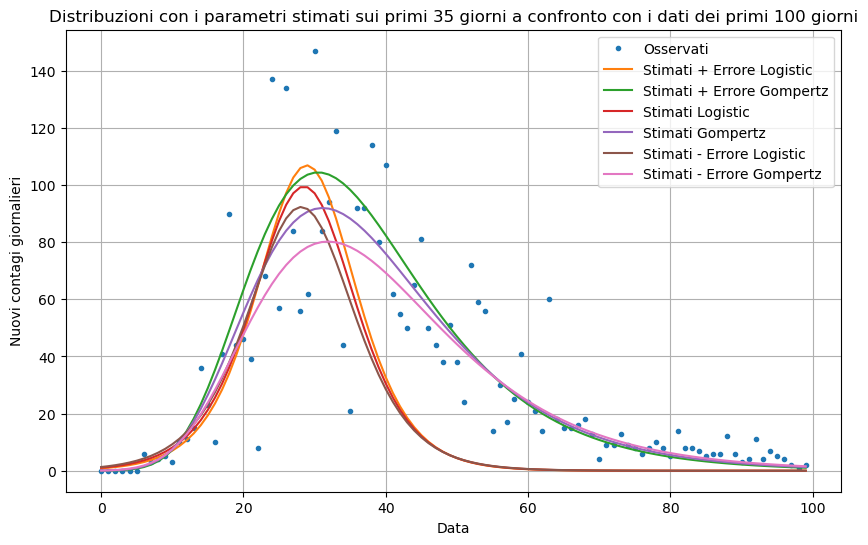

In [478]:
#grafico dei primi 100 giorni

t = np.arange(0, 100,1)  # con 100 giorni

#P
PLN_tot=Lestimated_params[0]+Lparam_uncertainties[1,0]
PLk=Lestimated_params[1]+Lparam_uncertainties[1,1]
PLt0=Lestimated_params[2]+Lparam_uncertainties[1,2]

PGN_tot=Gestimated_params[0]+Gparam_uncertainties[1,0]
PGk=Gestimated_params[1]+Gparam_uncertainties[1,1]
PGt0=Gestimated_params[2]+Gparam_uncertainties[1,2]

PLy=logistic_daily_cases(PLN_tot, PLk, PLt0, t)
PGy=gompertz_daily_cases(PGN_tot, PGk, PGt0, t)

#distribuzione
LN_tot=Lestimated_params[0]
Lk=Lestimated_params[1]
Lt0=Lestimated_params[2]

GN_tot=Gestimated_params[0]
Gk=Gestimated_params[1]
Gt0=Gestimated_params[2]

Ly=logistic_daily_cases(LN_tot, Lk, Lt0, t)
Gy=gompertz_daily_cases(GN_tot, Gk, Gt0, t)

#M
MLN_tot=Lestimated_params[0]+Lparam_uncertainties[0,0]
MLk=Lestimated_params[1]+Lparam_uncertainties[0,1]
MLt0=Lestimated_params[2]+Lparam_uncertainties[0,2]

MGN_tot=Gestimated_params[0]+Gparam_uncertainties[0,0]
MGk=Gestimated_params[1]+Gparam_uncertainties[0,1]
MGt0=Gestimated_params[2]+Gparam_uncertainties[0,2]

MLy=logistic_daily_cases(MLN_tot, MLk, MLt0, t)
MGy=gompertz_daily_cases(MGN_tot, MGk, MGt0, t)

plt.figure(figsize=(10, 6))

plt.plot(t, n_positivi100, '.', label='Osservati')

# P
PLy = logistic_daily_cases(PLN_tot, PLk, PLt0, t)
PGy = gompertz_daily_cases(PGN_tot, PGk, PGt0, t)
plt.plot(t, PLy, label='Stimati + Errore Logistic')
plt.plot(t, PGy, label='Stimati + Errore Gompertz')

# Distribuzione
Ly = logistic_daily_cases(LN_tot, Lk, Lt0, t)
Gy = gompertz_daily_cases(GN_tot, Gk, Gt0, t)
plt.plot(t, Ly, label='Stimati Logistic')
plt.plot(t, Gy, label='Stimati Gompertz')

# M
MGLy = logistic_daily_cases(MLN_tot, MLk, MLt0, t)
MGy = gompertz_daily_cases(MGN_tot, MGk, MGt0, t)
plt.plot(t, MLy, label='Stimati - Errore Logistic')
plt.plot(t, MGy, label='Stimati - Errore Gompertz')

plt.title(f'Distribuzioni con i parametri stimati sui primi 35 giorni a confronto con i dati dei primi 100 giorni')
plt.grid(True)
plt.xlabel('Data')
plt.ylabel("Nuovi contagi giornalieri")
plt.legend()  # Aggiunge la legenda
plt.show()

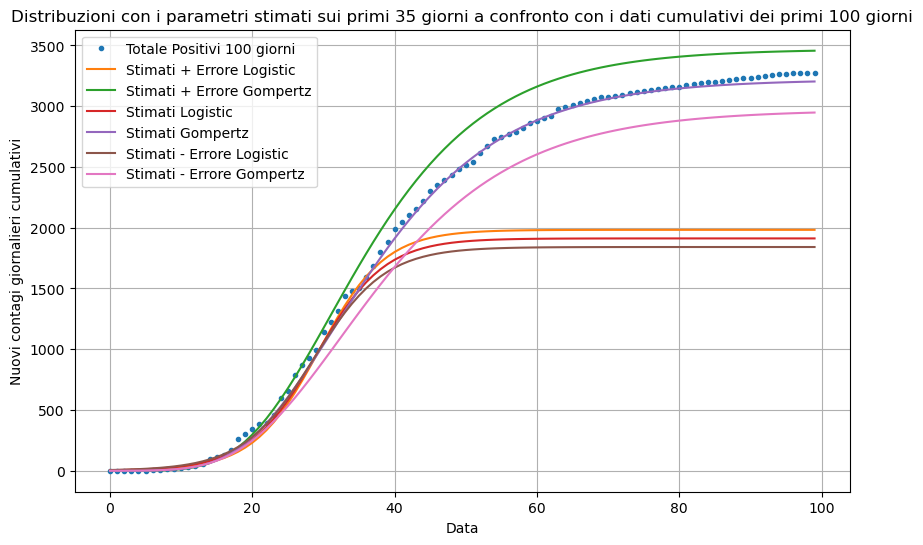

In [479]:
positivi100 = n_positivi100.to_numpy()
sommepositivi100 = np.cumsum(positivi100)

t = np.arange(0, 100, 1)  # con 100 giorni

# P
PLN_tot = Lestimated_params[0] + Lparam_uncertainties[1, 0]
PLk = Lestimated_params[1] + Lparam_uncertainties[1, 1]
PLt0 = Lestimated_params[2] + Lparam_uncertainties[1, 2]

PGN_tot = Gestimated_params[0] + Gparam_uncertainties[1, 0]
PGk = Gestimated_params[1] + Gparam_uncertainties[1, 1]
PGt0 = Gestimated_params[2] + Gparam_uncertainties[1, 2]

PLy = logistic_function(PLN_tot, PLk, PLt0, t)
PGy = gompertz_function(PGN_tot, PGk, PGt0, t)

# Distribuzione
LN_tot = Lestimated_params[0]
Lk = Lestimated_params[1]
Lt0 = Lestimated_params[2]

GN_tot = Gestimated_params[0]
Gk = Gestimated_params[1]
Gt0 = Gestimated_params[2]

Ly = logistic_function(LN_tot, Lk, Lt0, t)
Gy = gompertz_function(GN_tot, Gk, Gt0, t)

# M
MLN_tot = Lestimated_params[0] + Lparam_uncertainties[0, 0]
MLk = Lestimated_params[1] + Lparam_uncertainties[0, 1]
MLt0 = Lestimated_params[2] + Lparam_uncertainties[0, 2]

MGN_tot = Gestimated_params[0] + Gparam_uncertainties[0, 0]
MGk = Gestimated_params[1] + Gparam_uncertainties[0, 1]
MGt0 = Gestimated_params[2] + Gparam_uncertainties[0, 2]

MLy = logistic_function(MLN_tot, MLk, MLt0, t)
MGy = gompertz_function(MGN_tot, MGk, MGt0, t)

plt.figure(figsize=(10, 6))
plt.plot(t, sommepositivi100, '.', label='Totale Positivi 100 giorni')

# P
plt.plot(t, PLy, label='Stimati + Errore Logistic')
plt.plot(t, PGy, label='Stimati + Errore Gompertz')

# Distribuzione
plt.plot(t, Ly, label='Stimati Logistic')
plt.plot(t, Gy, label='Stimati Gompertz')

# M
plt.plot(t, MLy, label='Stimati - Errore Logistic')
plt.plot(t, MGy, label='Stimati - Errore Gompertz')

plt.grid(True)
plt.title(f'Distribuzioni con i parametri stimati sui primi 35 giorni a confronto con i dati cumulativi dei primi 100 giorni')
plt.xlabel("Data")
plt.ylabel("Nuovi contagi giornalieri cumulativi")
plt.legend()
plt.show()


Notiamo come, mentre nella fase di crescita esponenziale iniziale le due distribuzioni funzionano ugualmente bene, nella fase di decrescita dei contagi la funzione di Gompertz riproduce molto meglio l'andamento sia dei dati sui casi giornalieri che cumulativi, mentre la funzione logistica tende a sottostimare il numero di casi durante questa fase. Concludiamo quindi che, alla luce dei dati riguardanti la fase di crescita esponenziale, la funzione di Gompertz si presta molto bene a previsioni teoriche sull'andamento di un epidemia nella sua fase di decrescita.   

# **Parte 4: Modellizzazione dell'Intervallo 3 Giugno 2020 - 3 Giugno 2021**
Consideriamo ora un intervallo temporale più ampio:

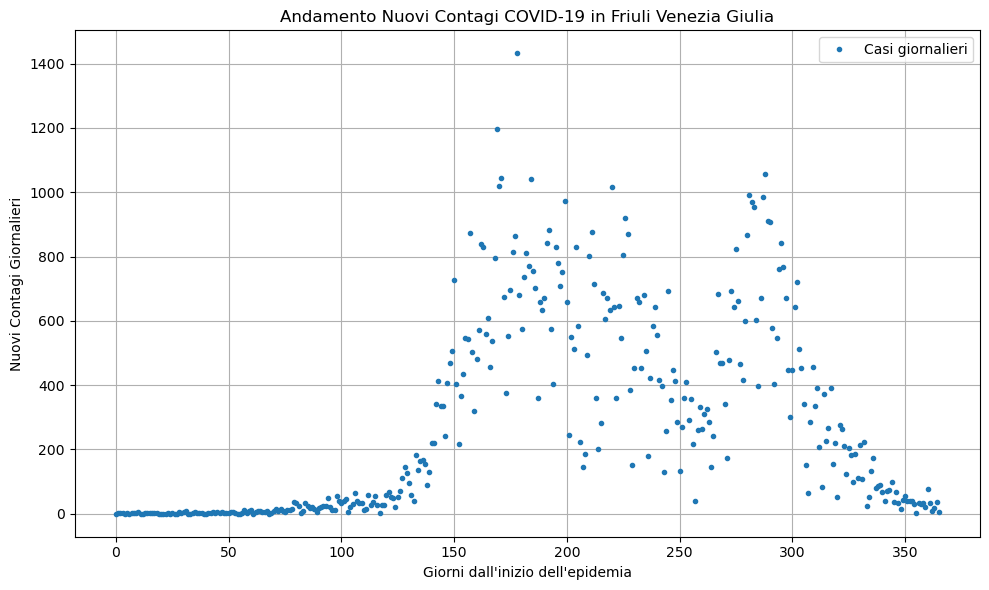

In [480]:
#Considero l'intervallo di un anno

# Definisci le date iniziali e finali
datain = "2020-06-03T17:00:00"
datafin = "2021-06-03T17:00:00"

# Crea una nuova serie con i nomi da start_name a end_name
dataanno = data[(data >= datain) & (data <= datafin)]

#seleziono quindi unicamente i contagi corrispondenti

n_positivianno = n_positivi[dataanno.index]
# Dati osservati
t = np.arange(0, 366, 1)  # con 366 giorni
Nosservati = n_positivianno.to_numpy()
plt.figure(figsize=(10, 6))
plt.title(f'Andamento Nuovi Contagi COVID-19 in Friuli Venezia Giulia')
plt.xlabel('Giorni dall\'inizio dell\'epidemia')
plt.ylabel('Nuovi Contagi Giornalieri')

plt.plot(t, n_positivianno, '.', label='Casi giornalieri')
plt.legend()
plt.grid(True)
plt.tight_layout()




Avendo a che fare con due picchi distinti, per la modellizzazione dell'epidemia usiamo una funzione data la somma di due funzioni di Gompertz (che abbiamo verificato essere il tipo di mappa ideale per modellizzare la situazione, in particolare in fase di decrescita) con parametri tra loro indipendenti. 

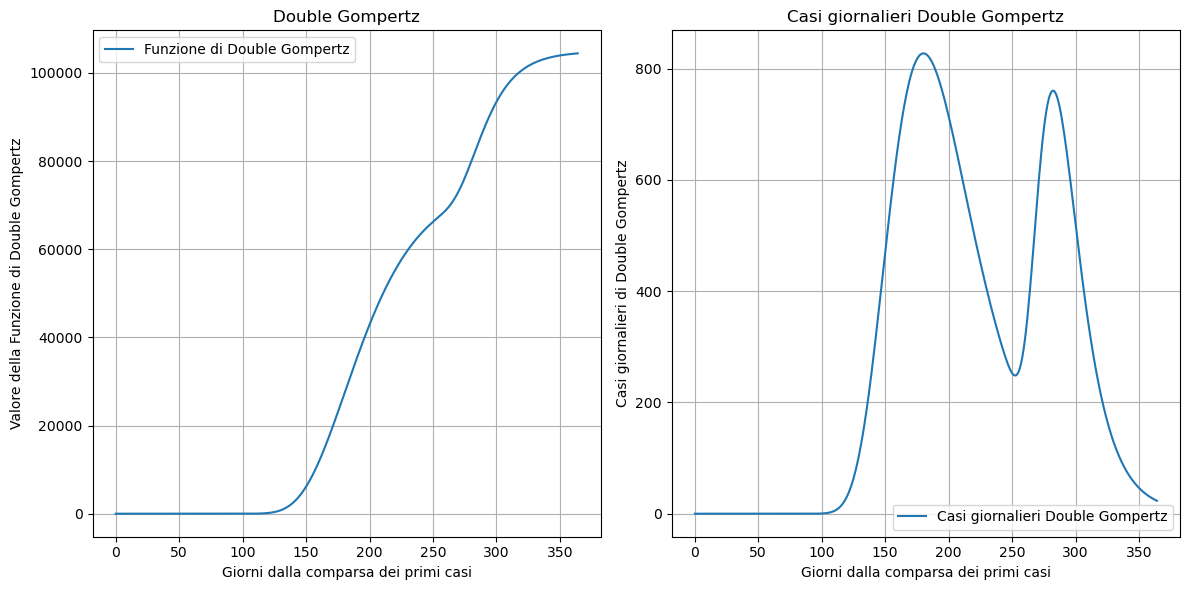

In [481]:
import numpy as np
import matplotlib.pyplot as plt

def double_gompertz_function(N_tot1, k1, t_01, N_tot2, k2, t_02, t):
    return N_tot1 * np.exp(-np.log(N_tot1) * np.exp(-k1 * (t - t_01)))+N_tot2 * np.exp(-np.log(N_tot2) * np.exp(-k2 * (t - t_02)))

def double_gompertz_daily_cases(N_tot1, k1, t_01, N_tot2, k2, t_02, t):
    return double_gompertz_function(N_tot1, k1, t_01, N_tot2, k2, t_02, t + 1) - double_gompertz_function(N_tot1, k1, t_01, N_tot2, k2, t_02, t)

# Esempio di utilizzo
t_values = np.arange(0, 365, 1)  # Array di tempi da 0 a 365
N_tot1_example = 75000
k1_example = 0.03
t01_example = 100
N_tot2_example = 30000
k2_example = 0.06
t02_example = 245

double_gompertz_values = double_gompertz_function(N_tot1_example, k1_example, t01_example, N_tot2_example, k2_example, t02_example, t_values)
double_daily_cases_gompertz = double_gompertz_daily_cases(N_tot1_example, k1_example, t01_example, N_tot2_example, k2_example, t02_example, t_values)

# Visualizzazione dei risultati
plt.figure(figsize=(12, 6))

# Grafico della funzione di Double Gompertz
plt.subplot(1, 2, 1)
plt.plot(t_values, double_gompertz_values, label='Funzione di Double Gompertz')
plt.title('Double Gompertz')
plt.xlabel('Giorni dalla comparsa dei primi casi')
plt.ylabel('Valore della Funzione di Double Gompertz')
plt.grid(True)
plt.legend()

# Casi giornalieri funzione di Double Gompertz
plt.subplot(1, 2, 2)
plt.plot(t_values, double_daily_cases_gompertz, label='Casi giornalieri Double Gompertz')
plt.title('Casi giornalieri Double Gompertz')
plt.xlabel('Giorni dalla comparsa dei primi casi')
plt.ylabel('Casi giornalieri di Double Gompertz')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Provo a testare alcuni valori dei parametri per trovare quelli che meglio approssimano la distribuzione dei dati, da usare come parametri iniziali nell'algoritmo.

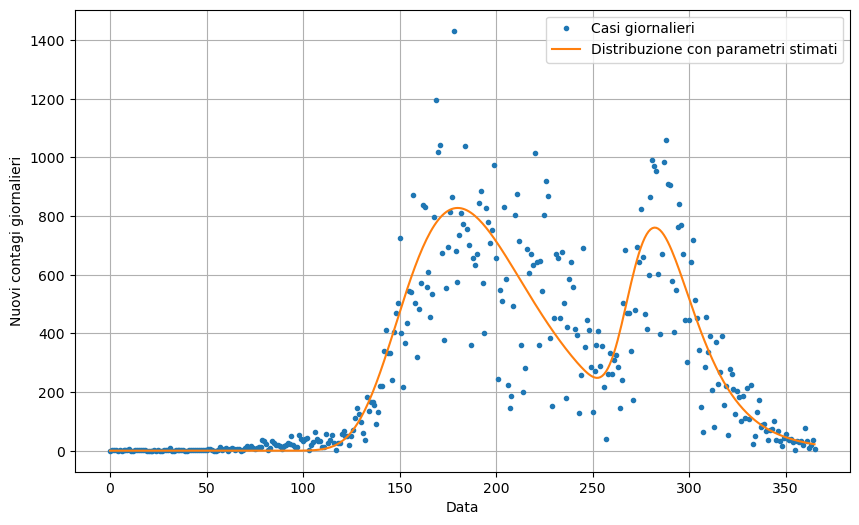

In [482]:
#FIT DELLA DISTRIBUZIONE CON I PARAMETRI INIZIALI FORNITI


t = np.arange(0, 366,1)  # con 366 giorni



#parametristimati

GN_tot1=75000
Gk1=0.03
Gt01=100
GN_tot2=30000
Gk2=0.06
Gt02=245

Gy=double_gompertz_daily_cases(GN_tot1, Gk1, Gt01, GN_tot2, Gk2, Gt02, t)

plt.figure(figsize=(10, 6))
plt.plot(t, n_positivianno, '.', label='Casi giornalieri')

#funzionestimata
plt.plot(t, (Gy), label='Distribuzione con parametri stimati')

plt.legend()
plt.grid(True)
plt.xlabel('Data')
plt.ylabel("Nuovi contagi giornalieri")
plt.show()

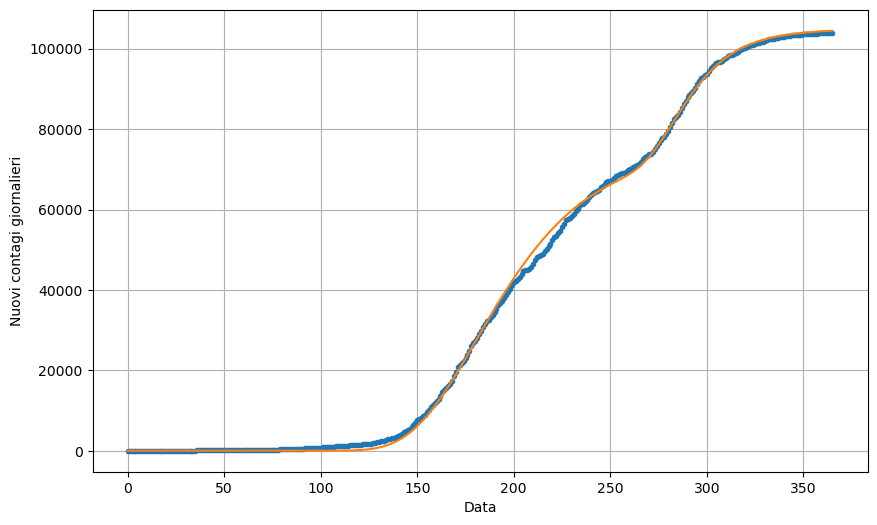

In [483]:
#FIT DELLA DISTRIBUZIONE CUMULATIVA CON I DATI INIZIALI FORNITI
positivianno=n_positivianno.to_numpy()

sommepositivianno=np.cumsum(positivianno)

t = np.arange(0, 366,1)  # con 366 giorni

#Parametri stimati cumulativa


GN_tot1=75000
Gk1=0.03
Gt01=100
GN_tot2=30000
Gk2=0.06
Gt02=245

Gy=double_gompertz_function(GN_tot1, Gk1, Gt01, GN_tot2, Gk2, Gt02, t)

plt.figure(figsize=(10, 6))
plt.plot(t, sommepositivianno, '.', label='Positivi cumulati')


#Cumulativa

plt.plot(t, (Gy), label='Distribuzione cumulativa con parametri stimati')

plt.grid(True)
plt.xlabel("Data")
plt.ylabel("Nuovi contagi giornalieri")
plt.show()

C:\Users\loren\anaconda3\Lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
  0%|          | 0/1000 [00:00<?, ?it/s]C:\Users\loren\anaconda3\Lib\site-packages\emcee\moves\red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 1000/1000 [00:06<00:00, 143.45it/s]


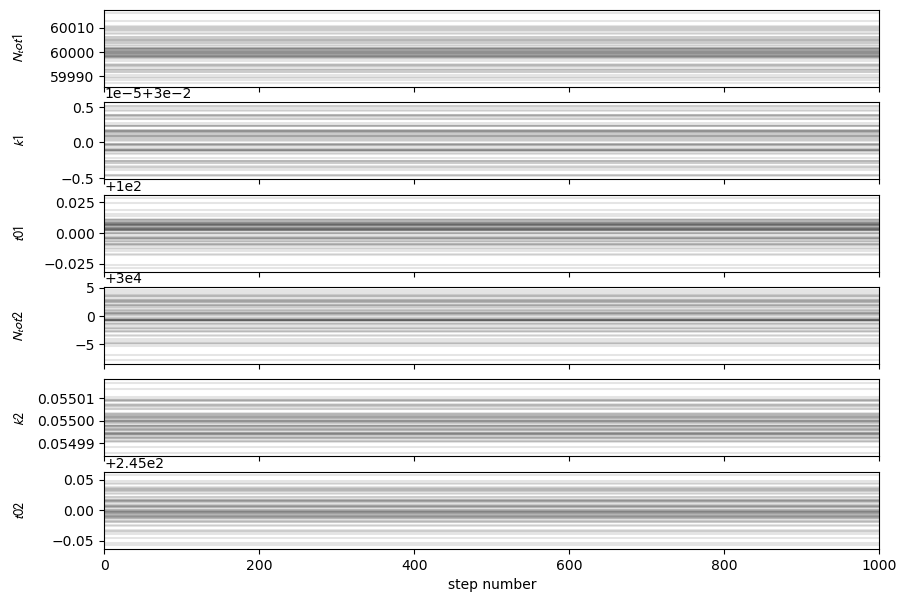

In [484]:
#Applicazione dell'algoritmo alla funzione double_gompertz



# Log-likelihood della distribuzione di Poisson

def log_likelihood(params, t, osservati): #poissoniana associata alla gompertz
    Ntot1, k1, t_01, Ntot2, k2, t_02 = params
    predetti= double_gompertz_daily_cases(Ntot1, k1, t_01, Ntot2, k2, t_02, t)
    log_likelihood = np.nansum( (-predetti) +  (osservati)*(np.log(predetti)) - (np.log(gamma(osservati.astype(int) + 1))) )
    return log_likelihood


# Logaritmo della prior
def Glog_prior(params):
    Ntot1, k1, t_01, Ntot2, k2, t_02 = params
    if Ntot1 > 0 and k1 > 0 and t_01 > 0 and Ntot2 > 0 and k2 > 0 and t_02 > 0:
        return 0
    return -np.inf

# Logaritmo del posterior
def log_posterior(params, t, osservati):
    Ntot1, k1, t_01, Ntot2, k2, t_02 = params
    lp = Glog_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(params, t, osservati)


# Dati osservati
t = np.arange(0, 366, 1)  # con 366 giorni
Nosservati = n_positivianno.to_numpy()


#PARAMETRI INIZIALI ARBITRARI

Ntot1ini = 60000# Totale dei contagi a fine seconda ondata epidemica
k1ini = 0.03# Velocità di propagazione del contagio
t01ini = 100 # Giorno di contagio del paziente 0 seconda ondata epidemica
Ntot2ini = 30000# Totale dei contagi a fine terza ondata epidemica
k2ini = 0.055# Velocità di propagazione del contagio
t02ini = 245 # Giorno di contagio del paziente 0 terza ondata epidemica

# Inizializzazione dei parametri
parametri_iniziali = [Ntot1ini, k1ini, t01ini, Ntot2ini, k2ini, t02ini]  # Inserire valori iniziali per Ntot, k, x0

nll = lambda *args: -log_posterior(*args)

# Ottimizzazione della log-likelihood
result = minimize(nll, parametri_iniziali, args=(t, Nosservati))

# Estrazione dei parametri stimati
GNtot1_estimated, Gk1_estimated, Gt01_estimated, GNtot2_estimated, Gk2_estimated, Gt02_estimated = result.x

#Inizializzazione di emcee
ndim=6 #numero parametri modello
nwalkers=64 #numero di catene di Markov

#codice ricavato da esercizio4

pos = result.x *(1+ 1e-4 * np.random.randn( nwalkers , ndim ))
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_posterior, args=(t,Nosservati)
)
sampler.run_mcmc(pos, 1000, progress=True);



fig, axes = plt.subplots(6, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["$N_tot1$","$k1$", "$t01$", "$N_tot2$","$k2$", "$t02$"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.1)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");


# Calcolo dei valori stimati dei parametri e delle incertezze
Gestimated_params = np.mean(samples, axis=(0,1))
Gparam_uncertainties = np.percentile(samples, [16, 84], axis=(0,1)) - Gestimated_params




Per ovviare ai problemi nel funzionamento dell'algoritmo, probabilmente dati dalla presenza dei due picchi nel funzionamento dell'algoritmo EMCEE proviamo a selezionare due intervalli temporali distinti e applicare un fit per la stima dei parametri di due funzioni di Gompertz distinte che poi andremo a sommare, trascurandone la sovrapposizione.

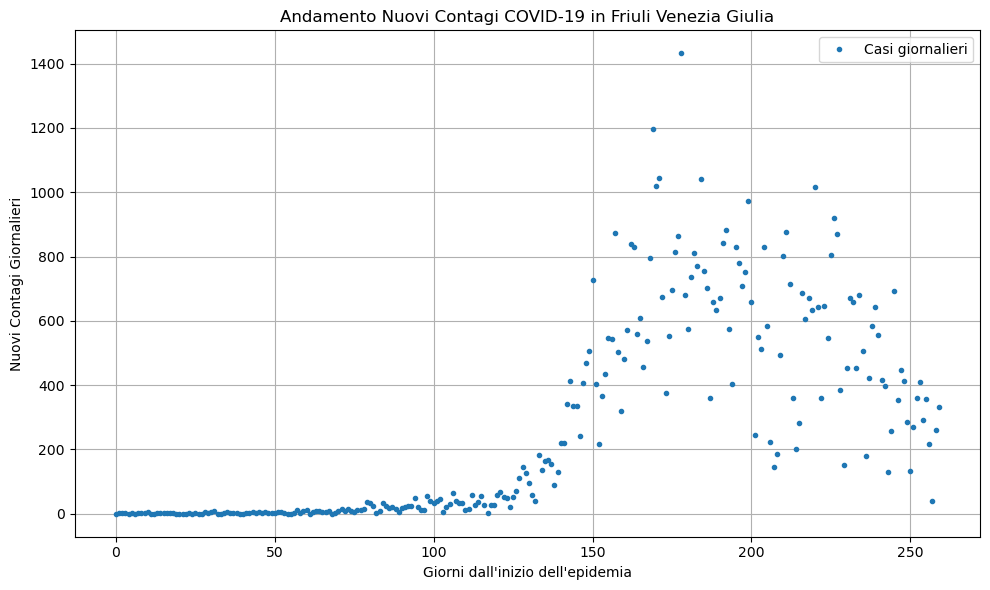

In [485]:
#Primo intervallo temporale (associato al primo picco)

# Definisci le date iniziali e finali
datain = "2020-06-03T17:00:00"
datafin = "2021-02-17T17:00:00"

# Crea una nuova serie con i nomi da start_name a end_name
dataprimo = data[(data >= datain) & (data <= datafin)]

#seleziono quindi unicamente i contagi corrispondenti

n_positiviprimo = n_positivi[dataprimo.index]
# Dati osservati
t = np.arange(0, 260, 1)  # con 260 giorni
Nosservati = n_positiviprimo.to_numpy()
plt.figure(figsize=(10, 6))
plt.title(f'Andamento Nuovi Contagi COVID-19 in Friuli Venezia Giulia')
plt.xlabel('Giorni dall\'inizio dell\'epidemia')
plt.ylabel('Nuovi Contagi Giornalieri')

plt.plot(t, n_positiviprimo, '.', label='Casi giornalieri')
plt.legend()
plt.grid(True)
plt.tight_layout()


100%|██████████| 5000/5000 [00:13<00:00, 370.88it/s]


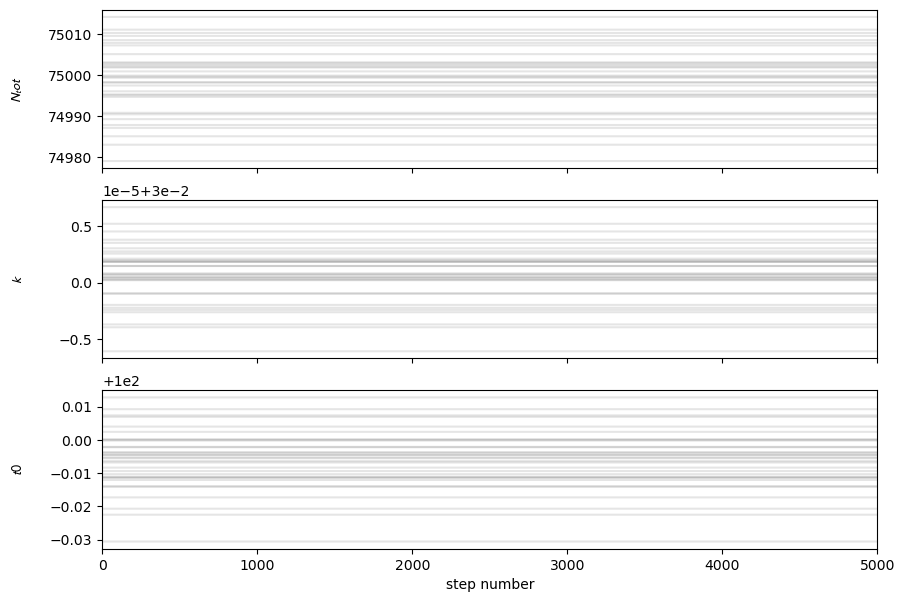

In [486]:
#GOMPERTZ

# l'uso dei logaritmi delle distribuzioni è dovuto alla maggior efficienza computazionale di svolgere somme anzichè prodotti

# Calcolo della log-likelihood della distribuzione di Poisson

# probabilità di ottenere il set di dati sperimentali osservati fissati i parametri e la distribuzione.

def log_likelihood(params, t, osservati): #likelihood poissoniana associata a gompertz
    Ntot, k, t_0 = params
    predetti= gompertz_daily_cases(Ntot, k, t_0, t)
    log_likelihood = np.nansum( (-predetti) +  (osservati)*(np.log(predetti)) - (np.log(gamma(osservati.astype(int) + 1))) )
    return log_likelihood

# Definizione del logaritmo del prior piatto

# distribuzione dei parametri dipendente solo dal modello statistico scelto inizialmente e non dai dati

def Glog_prior(params):
    Ntot, k, t_0 = params
    if Ntot > 0 and k > 0 and t_0 > 0:
        return 0
    return -np.inf

# distribuzione dei parametri alla luce del modello e dei dati

# Definizione del logaritmo del posterior

def log_posterior(params, t, osservati):
    Ntot, k, t_0 = params
    lp = Glog_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(params, t, osservati)


# Dati osservati nei primi 260 giorni dell'epidemia

t = np.arange(0, 260,1) 
Nosservati = n_positiviprimo.to_numpy()


#PARAMETRI INIZIALI 

Ntotini = 75000# Totale dei contagi a fine ondata epidemica
kini = 0.03# Velocità di propagazione del contagio
t0ini = 100 # Giorno di contagio del paziente 0

# Inizializzazione dei parametri
parametri_iniziali = [Ntotini, kini, t0ini]  # Inserire valori iniziali per Ntot, k, x0

nll = lambda *args: -log_posterior(*args)

# Ottimizzazione della log-likelihood
result = minimize(nll, parametri_iniziali, args=(t, Nosservati))

# Estrazione dei parametri stimati
GNtot_estimated, Gk_estimated, Gt0_estimated = result.x

#Inizializzazione di emcee
ndim=3 #numero parametri modello
nwalkers=32 #numero di walkers opportunamente scelto pari a circa 10 volte il numero di parametri da stimare

#i walkers vengono inizializzati a partire dalla combinazione di parametri che massimizzano la log_posterior

pos = result.x *(1+ 1e-4 * np.random.randn( nwalkers , ndim ))
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_posterior, args=(t,Nosservati)
)
sampler.run_mcmc(pos, 5000, progress=True);  
#preferibile che il numero di step sia una cinquantina di volte il tempo di autocorrelazione per ogni parametro


fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["$N_tot$","$k$", "$t0$"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.1)  #il parametro alpha regola la trasparenza delle linee
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

#stampa il tempo di autocorrelazione, cioè il tempo necessario a decorrelare campionamenti successivi
#è necessario che tau sia basso rispetto al numero totale di step di ciascuna catena di Markov

#tau = sampler.get_autocorr_time()
#print(tau)
#flat_samples = sampler.get_chain(discard=100, flat=True)
#print(flat_samples.shape)

#stampa le posterior distribution e le covarianze tra i parametri, che rappresentano il tempo 
#passato dalle catene di Markov in ciascuna 'regione' all'interno dello spazio dei parametri 

#import pygtc
#GTC = pygtc.plotGTC(chains=flat_samples,
#                    paramNames=['$N_tot$','$k$','$t_0$'],
#                    chainLabels=['Parametri'],
#                    figureSize='MNRAS_page')

# Calcolo dei valori stimati dei parametri e delle incertezze

Gestimated_params = np.mean(samples, axis=(0,1)) #media
Gparam_uncertainties = np.percentile(samples, [16, 84], axis=(0,1)) - Gestimated_params 
#calcolo dell'incertezza come differenza tra valori associati a 16o e 84o percentile e media



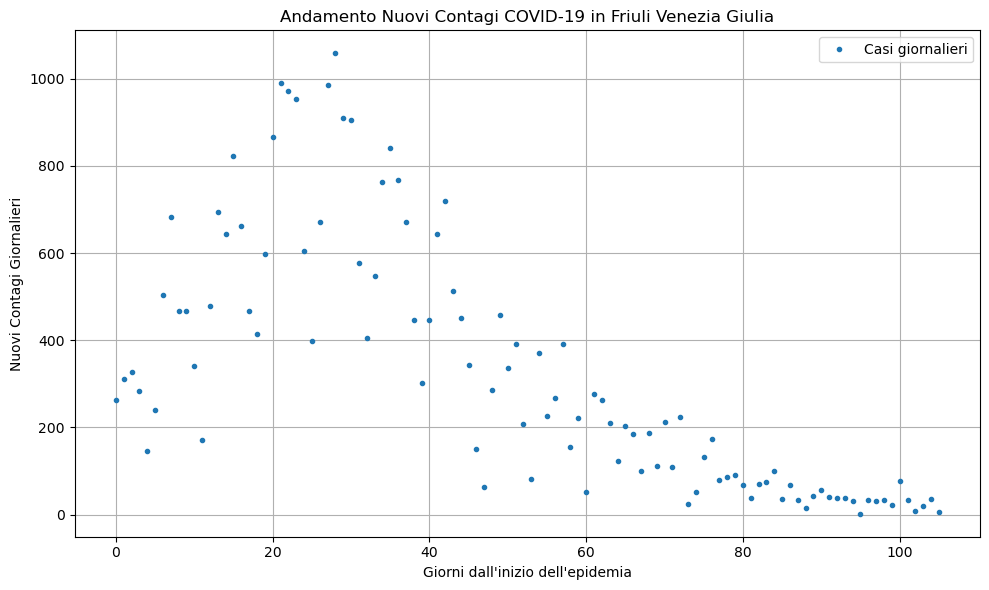

In [487]:
#Primo intervallo temporale (associato al primo picco)

# Definisci le date iniziali e finali
datain = "2021-02-18T17:00:00"
datafin = "2021-06-03T17:00:00"

# Crea una nuova serie con i nomi da start_name a end_name
datasecondo = data[(data >= datain) & (data <= datafin)]

#seleziono quindi unicamente i contagi corrispondenti

n_positivisecondo = n_positivi[datasecondo.index]
# Dati osservati
t = np.arange(0, 106, 1)  # con 106 giorni
Nosservati = n_positivisecondo.to_numpy()
plt.figure(figsize=(10, 6))
plt.title(f'Andamento Nuovi Contagi COVID-19 in Friuli Venezia Giulia')
plt.xlabel('Giorni dall\'inizio dell\'epidemia')
plt.ylabel('Nuovi Contagi Giornalieri')

plt.plot(t, n_positivisecondo, '.', label='Casi giornalieri')
plt.legend()
plt.grid(True)
plt.tight_layout()

100%|██████████| 5000/5000 [00:11<00:00, 428.24it/s]


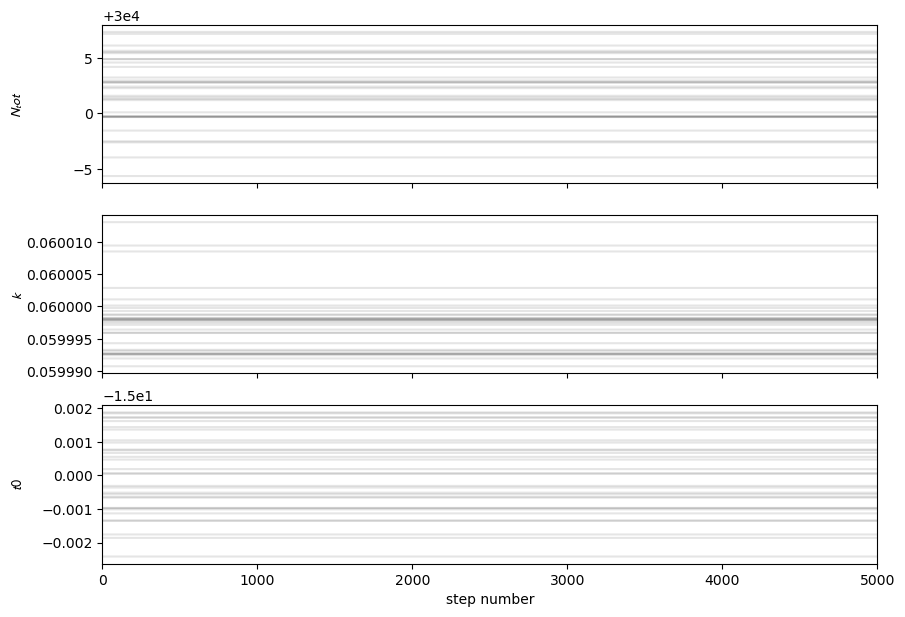

In [488]:
#GOMPERTZ

# l'uso dei logaritmi delle distribuzioni è dovuto alla maggior efficienza computazionale di svolgere somme anzichè prodotti

# Calcolo della log-likelihood della distribuzione di Poisson

# probabilità di ottenere il set di dati sperimentali osservati fissati i parametri e la distribuzione.

def log_likelihood(params, t, osservati): #likelihood poissoniana associata a gompertz
    Ntot, k, t_0 = params
    predetti= gompertz_daily_cases(Ntot, k, t_0, t)
    log_likelihood = np.nansum( (-predetti) +  (osservati)*(np.log(predetti)) - (np.log(gamma(osservati.astype(int) + 1))) )
    return log_likelihood

# Definizione del logaritmo del prior piatto

# distribuzione dei parametri dipendente solo dal modello statistico scelto inizialmente e non dai dati

def Glog_prior(params):
    Ntot, k, t_0 = params
    if Ntot > 0 and k > 0:
        return 0
    return -np.inf

# distribuzione dei parametri alla luce del modello e dei dati

# Definizione del logaritmo del posterior

def log_posterior(params, t, osservati):
    Ntot, k, t_0 = params
    lp = Glog_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(params, t, osservati)


# Dati osservati nei primi 106 giorni dell'epidemia

t = np.arange(0, 106,1) 
Nosservati = n_positivisecondo.to_numpy()


#PARAMETRI INIZIALI 

Ntotini = 30000# Totale dei contagi a fine ondata epidemica
kini = 0.06# Velocità di propagazione del contagio
t0ini = -15 # Giorno di contagio del paziente 0

# Inizializzazione dei parametri
parametri_iniziali = [Ntotini, kini, t0ini]  # Inserire valori iniziali per Ntot, k, x0

nll = lambda *args: -log_posterior(*args)

# Ottimizzazione della log-likelihood
result = minimize(nll, parametri_iniziali, args=(t, Nosservati))

# Estrazione dei parametri stimati
GNtot_estimated, Gk_estimated, Gt0_estimated = result.x

#Inizializzazione di emcee
ndim=3 #numero parametri modello
nwalkers=32 #numero di walkers opportunamente scelto pari a circa 10 volte il numero di parametri da stimare

#i walkers vengono inizializzati a partire dalla combinazione di parametri che massimizzano la log_posterior

pos = result.x *(1+ 1e-4 * np.random.randn( nwalkers , ndim ))
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_posterior, args=(t,Nosservati)
)
sampler.run_mcmc(pos, 5000, progress=True);  
#preferibile che il numero di step sia una cinquantina di volte il tempo di autocorrelazione per ogni parametro


fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["$N_tot$","$k$", "$t0$"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.1)  #il parametro alpha regola la trasparenza delle linee
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

#stampa il tempo di autocorrelazione, cioè il tempo necessario a decorrelare campionamenti successivi
#è necessario che tau sia basso rispetto al numero totale di step di ciascuna catena di Markov

#tau = sampler.get_autocorr_time()
#print(tau)
#flat_samples = sampler.get_chain(discard=100, flat=True)
#print(flat_samples.shape)

#stampa le posterior distribution e le covarianze tra i parametri, che rappresentano il tempo 
#passato dalle catene di Markov in ciascuna 'regione' all'interno dello spazio dei parametri 

#import pygtc
#GTC = pygtc.plotGTC(chains=flat_samples,
#                    paramNames=['$N_tot$','$k$','$t_0$'],
#                    chainLabels=['Parametri'],
#                    figureSize='MNRAS_page')

# Calcolo dei valori stimati dei parametri e delle incertezze

Gestimated_params = np.mean(samples, axis=(0,1)) #media
Gparam_uncertainties = np.percentile(samples, [16, 84], axis=(0,1)) - Gestimated_params 
#calcolo dell'incertezza come differenza tra valori associati a 16o e 84o percentile e media



Anche in questo caso l'algoritmo fallisce, probabilmente a causa di un numero troppo alto di dati o un errore in fase di ottimizzazione della log likelihood. In linea teorica dovrebbe essere possibile ottenere dei parametri simili a quelli stimati graficamente.